In [48]:
import stlearn as st
from pathlib import Path
import scanpy as sc
st.settings.set_figure_params(dpi=300)
import matplotlib.pyplot as plt 
import pandas as pd
import scipy as sp
import histomicstk as htk
import skimage.io
import skimage.measure
import skimage.color
import skimage.filters
%matplotlib inline

In [2]:
from typing import Optional, Union
from anndata import AnnData
from stlearn._compat import Literal
from PIL import Image
from pathlib import Path

# Test progress bar
from tqdm import tqdm
import numpy as np
import os


def tiling(
    adata: AnnData,
    out_path: Union[Path, str] = "./tiling",
    library_id: str = None,
    crop_size: int = 40,
    target_size: int = 299,
    verbose: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """\
    Tiling H&E images to small tiles based on spot spatial location

    Parameters
    ----------
    adata
        Annotated data matrix.
    out_path
        Path to save spot image tiles
    library_id
        Library id stored in AnnData.
    crop_size
        Size of tiles
    verbose
        Verbose output
    copy
        Return a copy instead of writing to adata.
    target_size
        Input size for convolutional neuron network
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tile_path** : `adata.obs` field
        Saved path for each spot image tiles
    """

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"][library_id]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
        total=len(adata),
        desc="Tiling image",
        bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            #tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
#             tile = tile.resize((target_size, target_size))
            tile_name = str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)
            out_tile = Path(out_path) / (tile_name + ".png")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "PNG", quuality=100)

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None


In [3]:
BASE_PATH = Path("/scratch/90days/uqxtan9/breast_cancer_10x")
TILE_PATH = Path("./tiles")
TILE_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
SAMPLE = "Sampel1"
Sample1 = st.Read10X(BASE_PATH, library_id=SAMPLE, quality="fulres")
st.add.image(Sample1, imgpath= BASE_PATH/"V1_Breast_Cancer_Block_A_Section_1_image.tif",
             library_id=SAMPLE, quality="fulres")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue image to the object!


In [31]:
BASE_PATH = Path("/home/uqxtan9/90days/mouse_brain_coronal_v1")
TILE_PATH = Path("/tmp/tiles")
TILE_PATH.mkdir(parents=True, exist_ok=True)

In [32]:
SAMPLE = "Sampel1"
Sample1 = st.Read10X(BASE_PATH, library_id=SAMPLE, quality="fulres")
st.add.image(Sample1, imgpath= BASE_PATH/"V1_Adult_Mouse_Brain_image.tif",
             library_id=SAMPLE, quality="fulres")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added tissue image to the object!


In [33]:
for andata in [Sample1]:
    st.pp.filter_genes(andata,min_cells=1)
    st.pp.normalize_total(andata)
    st.pp.log1p(andata)
#     st.pp.scale(andata)
    st.em.run_pca(andata,n_comps=50)
    TILE_PATH_ = TILE_PATH / list(Sample1.uns["spatial"].keys())[0]
    tiling(andata, TILE_PATH_, crop_size=120)
    st.pp.extract_feature(andata)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract feature:   4%|▎          [ time left: 02:45 ]/home/uqxtan9/90days/.conda/envs/stlearn/lib/python3.8/site-packages/stlearn/image_preprocessing/feature_extractor.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df[spot] = features
Extract feature: 100%|██████████ [ time left: 00:00 ]


The morphology feature is added to adata.obsm['X_morphology']!


In [34]:
Sample1_SME = Sample1.copy()
st.spatial.SME.SME_normalize(Sample1_SME, use_data="raw")
Sample1_SME.X = Sample1_SME.obsm['raw_SME_normalized']
st.pp.scale(Sample1_SME)
st.em.run_pca(Sample1_SME,n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [13]:

# # louvain clustering on stSME normalised data
# st.pp.neighbors(Sample1_SME,n_neighbors=17,use_rep='X_pca')
# st.tl.clustering.louvain(Sample1_SME, resolution=1.20)
# st.pl.cluster_plot(Sample1_SME,use_label="louvain")

In [11]:
Sample1_SME.uns["spatial"]

{'Sampel1': {'images': {'fulres': array([[[190, 192, 187],
           [189, 192, 187],
           [188, 191, 188],
           ...,
           [189, 193, 190],
           [189, 192, 189],
           [190, 193, 189]],
   
          [[191, 194, 188],
           [190, 193, 188],
           [189, 193, 189],
           ...,
           [188, 192, 190],
           [190, 193, 190],
           [192, 195, 191]],
   
          [[192, 196, 189],
           [190, 193, 187],
           [191, 194, 189],
           ...,
           [191, 194, 191],
           [193, 196, 192],
           [192, 195, 190]],
   
          ...,
   
          [[190, 193, 191],
           [190, 193, 190],
           [189, 192, 188],
           ...,
           [187, 190, 185],
           [189, 192, 186],
           [188, 191, 186]],
   
          [[189, 192, 190],
           [188, 191, 189],
           [188, 191, 187],
           ...,
           [188, 191, 185],
           [189, 192, 187],
           [188, 191, 186]],
   
     

In [267]:
tile_path = Sample1_SME.obs["tile_path"][110]

In [268]:
imInput = skimage.io.imread(tile_path)

In [269]:
# plt.imshow(imInput_)
# plt.show()

In [410]:
Sample1

AnnData object with n_obs × n_vars = 3798 × 24923
    obs: 'in_tissue', 'array_row', 'array_col', 'sum_counts', 'imagecol', 'imagerow', 'tile_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'log1p', 'pca'
    obsm: 'spatial', 'filtered_counts', 'normalized_total', 'X_pca', 'X_tile_feature', 'X_morphology'
    varm: 'PCs'

In [270]:
# imInput = skimage.filters.gaussian(imInput_, multichannel=True)

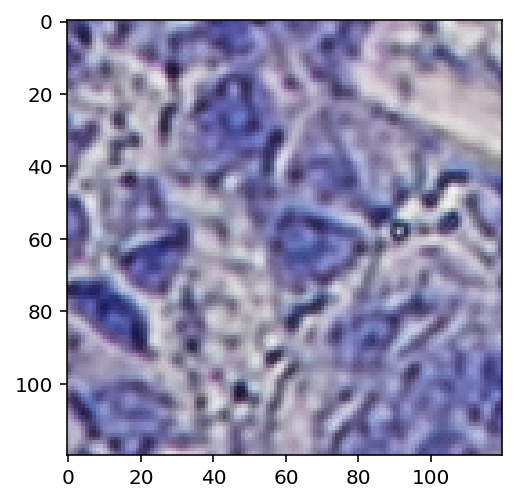

In [271]:
plt.imshow(imInput)
plt.show()

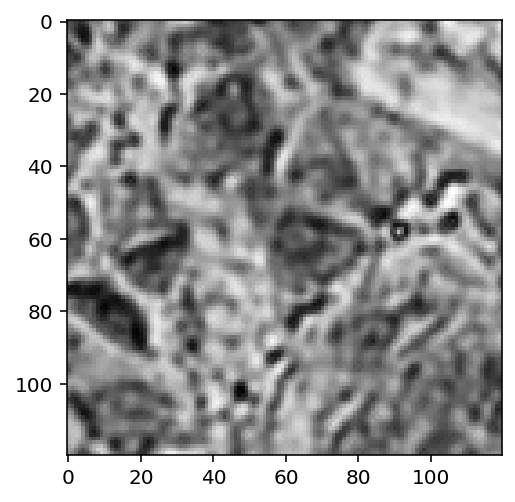

In [272]:
plt.imshow(imInput[:,:,0])
plt.show()

In [233]:
imInput.shape

(120, 120, 3)

In [234]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


In [12]:
# plt.rcParams['figure.figsize'] = 15, 15
# plt.rcParams['image.cmap'] = 'gray'
# titlesize = 24
# stains = ['hematoxylin',  # nuclei stain
#           'eosin',        # cytoplasm stain
#           'null']         # set to null if input contains only two stains

# w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, 255)

# # Perform color deconvolution
# deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, 255)

# print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# # Display results
# for i in 0, 1:
#     plt.figure()
#     # Unlike SNMF, we're not guaranteed the order of the different stains.
#     # find_stain_index guesses which one we want
#     channel = htk.preprocessing.color_deconvolution.find_stain_index(
#         stain_color_map[stains[i]], w_est)
#     plt.imshow(deconv_result.Stains[:, :, channel])
#     _ = plt.title(stains[i], fontsize=titlesize)
#     plt.show()

In [236]:
channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[0]], w_est)
channel

1

In [402]:
im_nuclei_stain = deconv_result.Stains[:, :, channel]
foreground_threshold = 120
im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)
# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15
im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)
# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 2

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))


Number of nuclei =  13


In [238]:
im_nuclei_stain

array([[103,  96,  69, ..., 228, 237, 249],
       [105,  98,  69, ..., 232, 243, 255],
       [109,  97,  64, ..., 235, 247, 255],
       ...,
       [196, 191, 178, ..., 122, 127, 136],
       [190, 187, 164, ..., 133, 140, 149],
       [180, 177, 158, ..., 163, 171, 169]], dtype=uint8)

In [407]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

thresh = skimage.filters.threshold_otsu(im_nuclei_stain)
# im_fgnd_mask = im_nuclei_stain < thresh
im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < thresh)

distance = ndi.distance_transform_edt(im_fgnd_mask)
coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)

labels = watershed(-distance, markers, mask=im_fgnd_mask)

min_nucleus_area = 80
im_nuclei_seg_mask = htk.segmentation.label.area_open(
    labels, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

Number of nuclei =  17


In [405]:
im_nuclei_seg_mask[im_nuclei_seg_mask>0] = 255
im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_nuclei_seg_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 2

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

Number of nuclei =  8


In [389]:
thresh

149

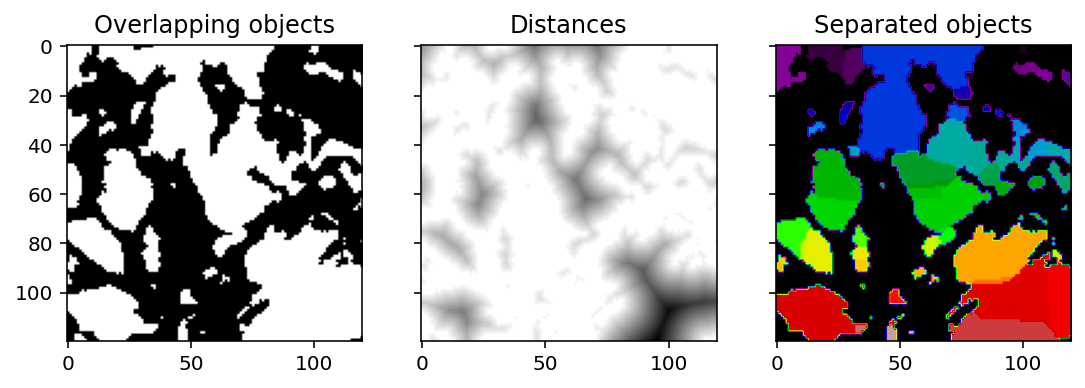

In [378]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im_fgnd_mask, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

plt.show()

In [380]:
im_nuclei_seg_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

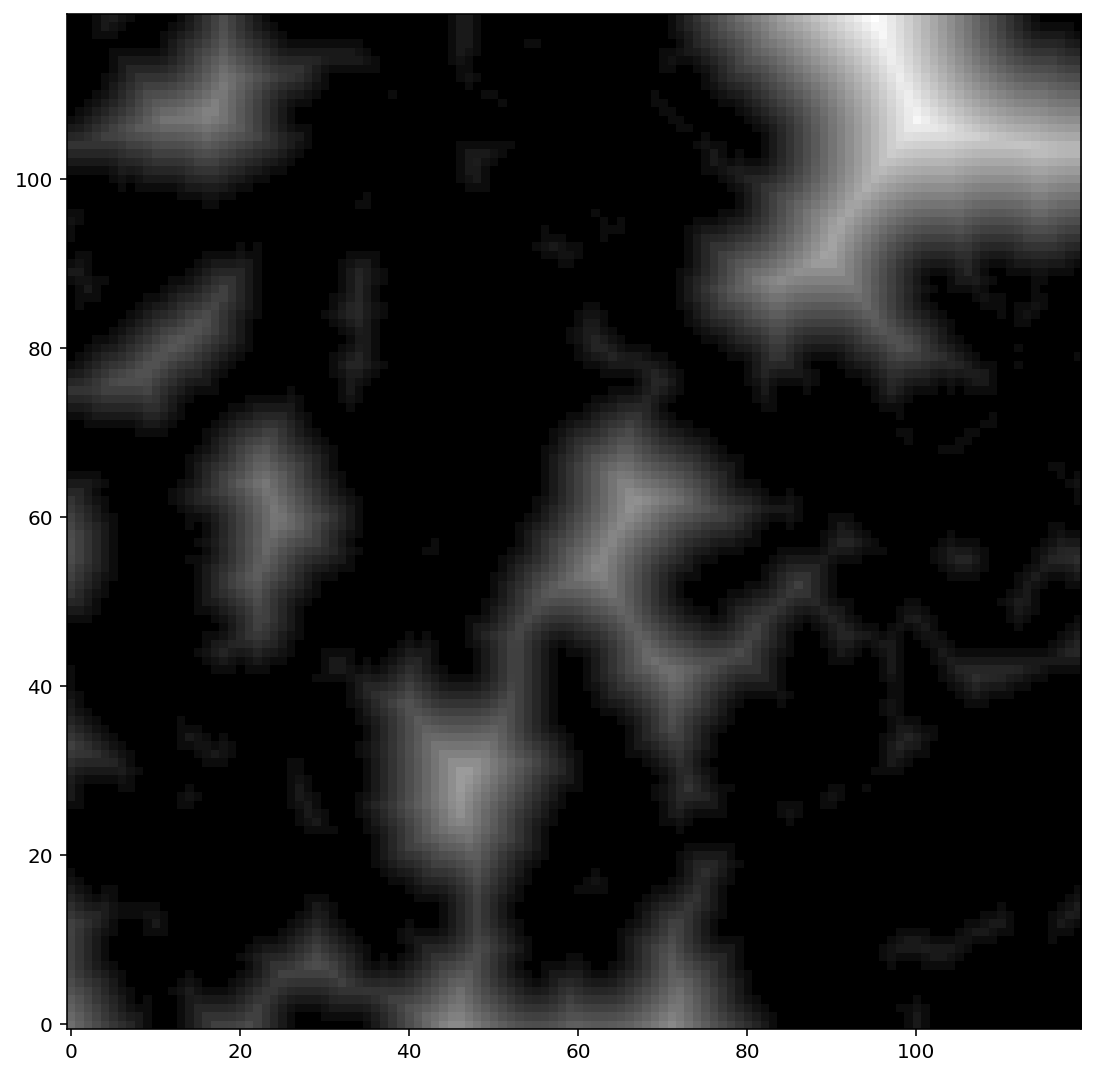

In [409]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(distance, origin='lower')


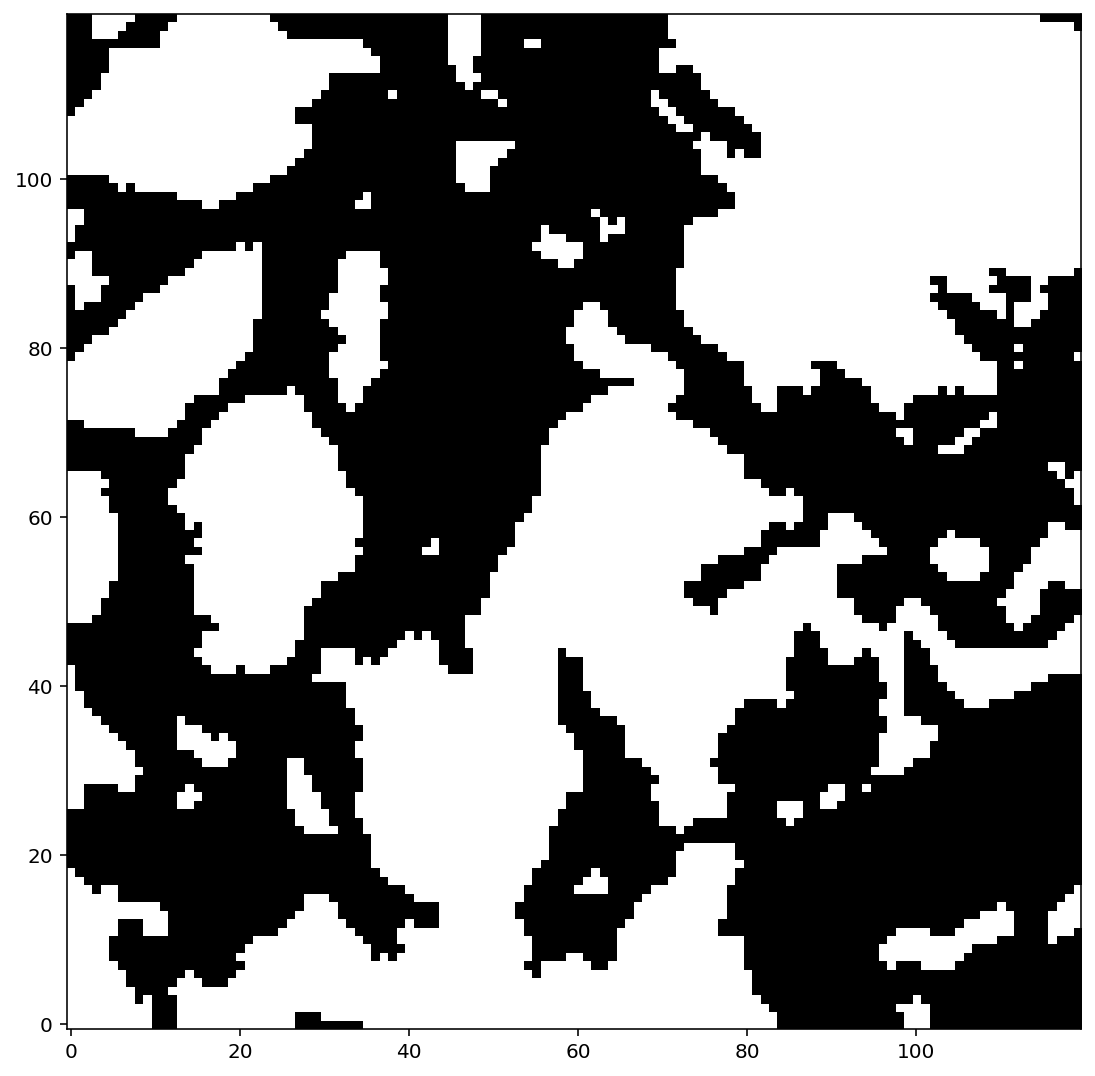

In [382]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_fgnd_mask, origin='lower')


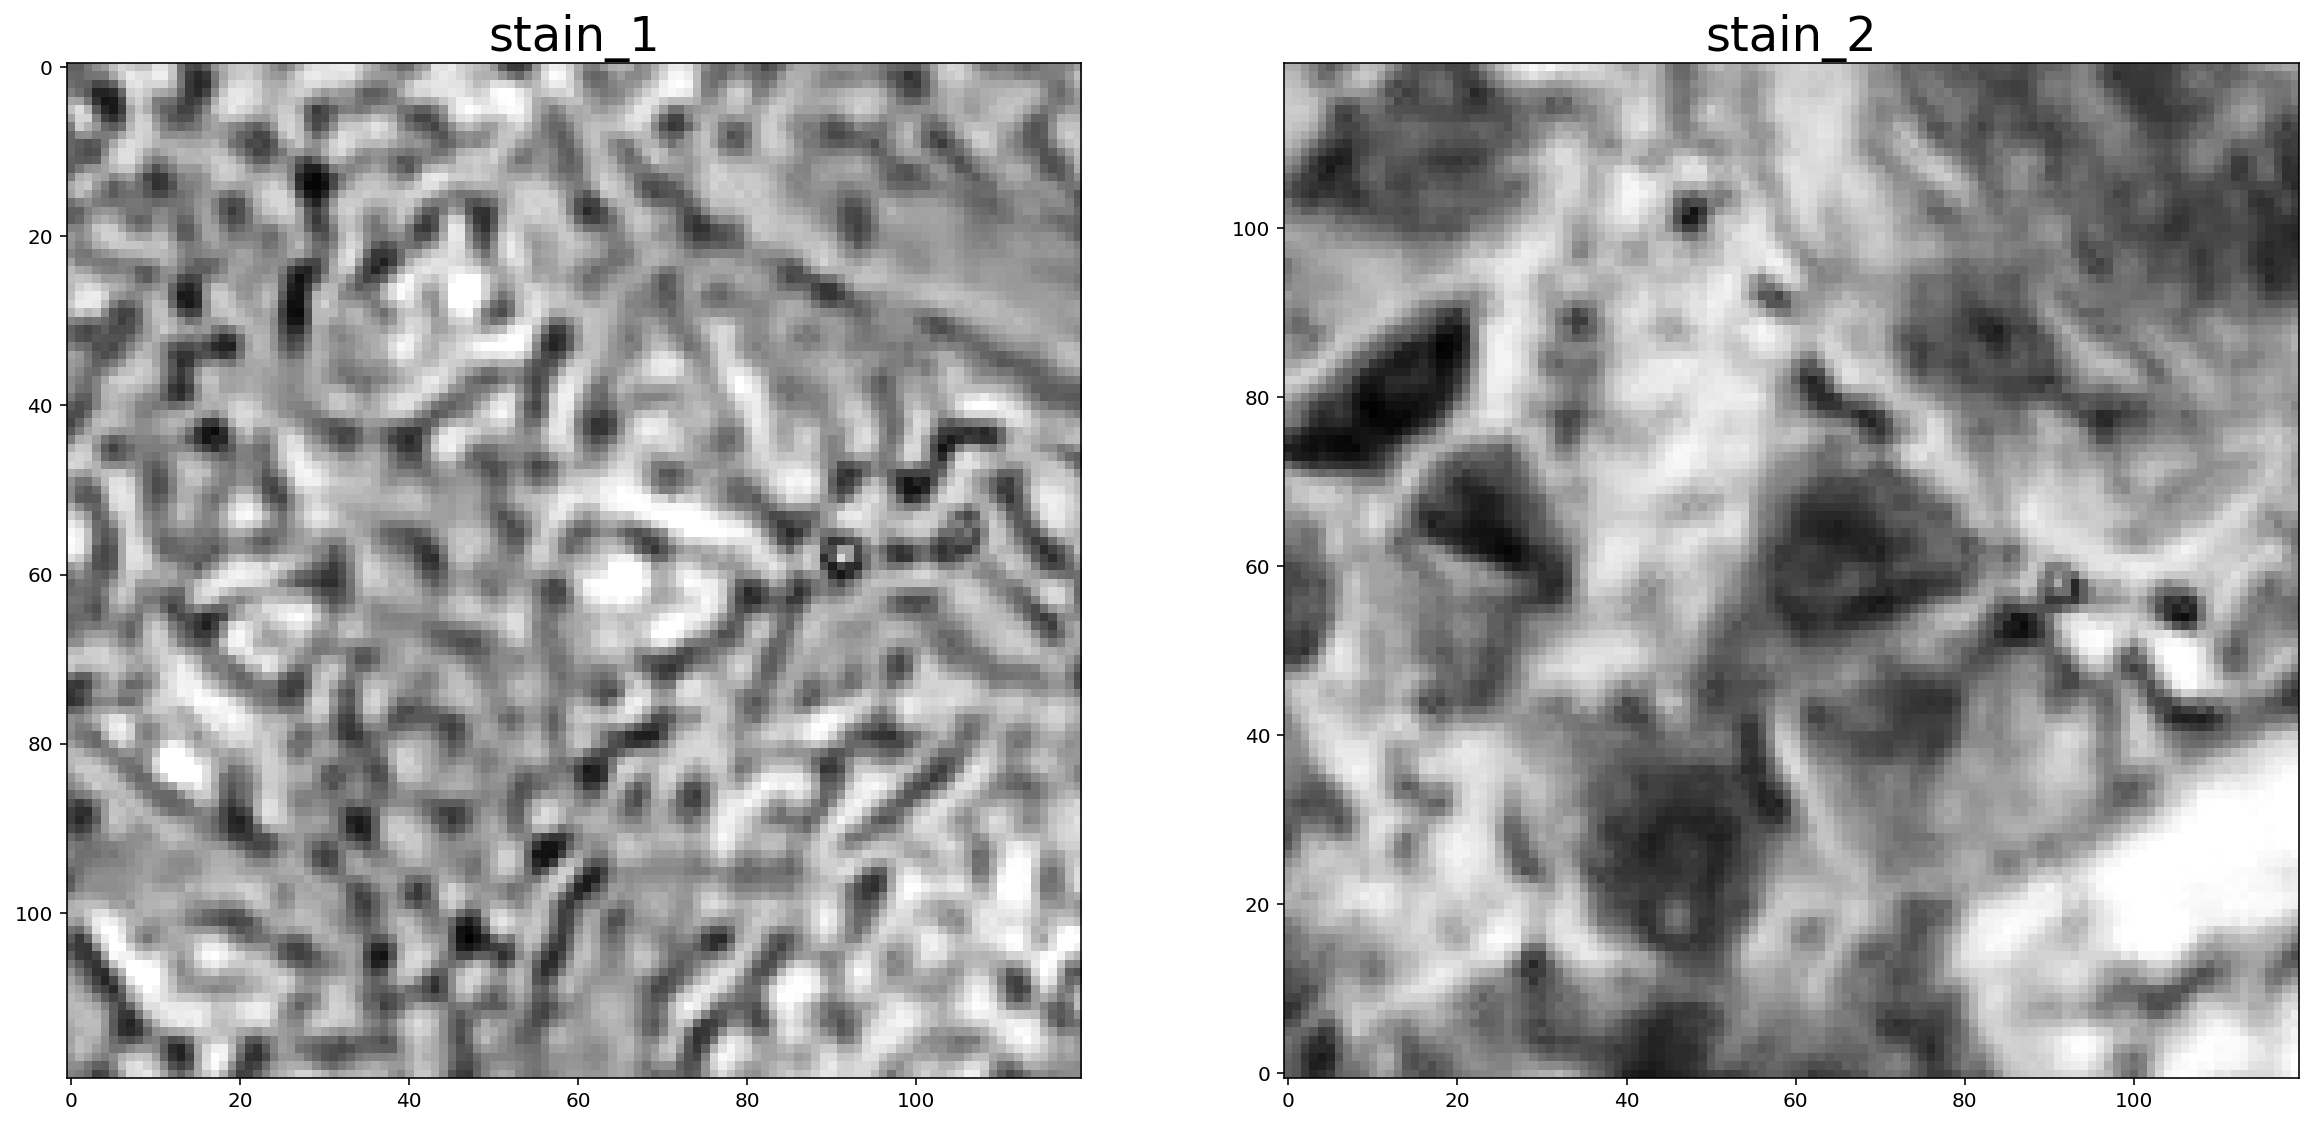

In [398]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(deconv_result.Stains[:, :, 0])
plt.title("stain_1", fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(deconv_result.Stains[:, :, 1], origin='lower')
_ = plt.title("stain_2", fontsize=titlesize)
plt.show()

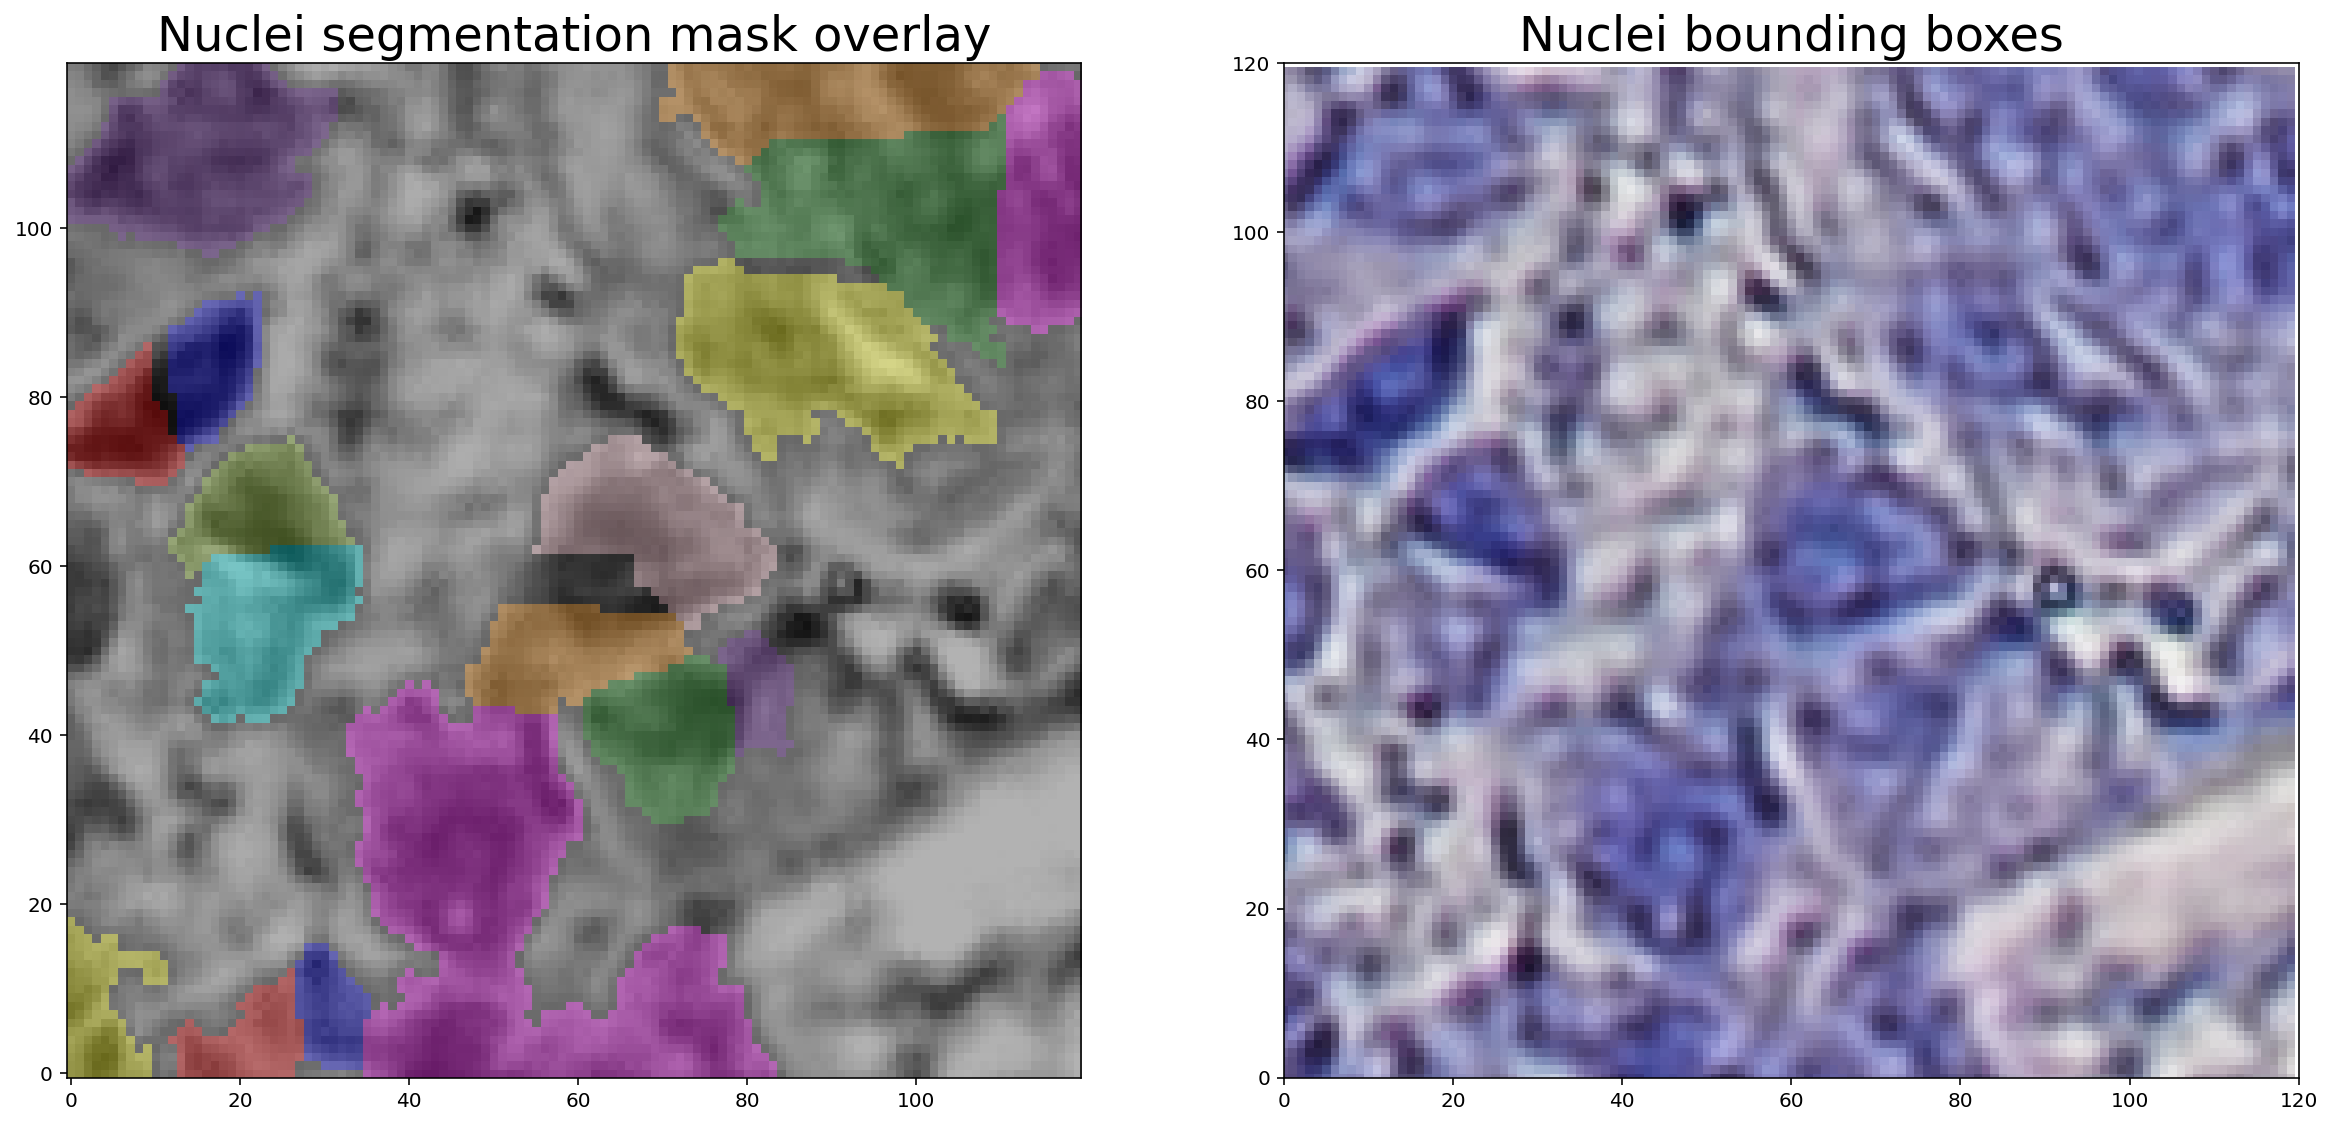

In [408]:
# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_nuclei_stain, bg_label=0), 
           origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( imInput )
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])

plt.title('Nuclei bounding boxes', fontsize=titlesize)
plt.show()

In [148]:
objProps

In [103]:
sum(map(lambda x: x.area, objProps))

10622

In [107]:
np.mean(list(map(lambda x: x.area, objProps)))

531.1

In [108]:
np.std(list(map(lambda x: x.area, objProps)))

277.3829302606777

In [119]:
objProps[3].solidity

-1.0396820544370458

In [99]:
imInput.reshape(3, -1).mean(1)

array([ 93.68462321,  92.41526381, 100.15924878])

In [100]:
imInput.reshape(3, -1).std(1)

array([33.06622931, 32.65581029, 28.56352861])

In [9]:
from typing import Optional, Union
from anndata import AnnData
from PIL import Image
from pathlib import Path
import pandas as pd
import scipy as sp
import histomicstk as htk
import skimage.io
import skimage.measure
import skimage.color

# Test progress bar
from tqdm import tqdm
import numpy as np
import os


def calculate_morph_stats(
    adata: AnnData,
    library_id: str = None,
    verbose: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """\
    Tiling H&E images to small tiles based on spot spatial location

    Parameters
    ----------
    adata
        Annotated data matrix.
    out_path
        Path to save spot image tiles
    library_id
        Library id stored in AnnData.
    crop_size
        Size of tiles
    verbose
        Verbose output
    copy
        Return a copy instead of writing to adata.
    target_size
        Input size for convolutional neuron network
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tile_path** : `adata.obs` field
        Saved path for each spot image tiles
    """

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]
    
    n_nuclei_list = []
    nuclei_total_area_list = []
    nuclei_mean_area_list = []
    nuclei_std_area_list = []
    eccentricity_list = []
    solidity_list = []
    mean_pix_list = []
    std_pix_list = []
    with tqdm(
        total=len(adata),
        desc="calculate morphological stats",
        bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for tile in adata.obs["tile_path"]:
            n_nuclei, \
            nuclei_total_area, \
            nuclei_mean_area, \
            nuclei_std_area, \
            eccentricity, \
            solidity, \
            mean_pix, \
            std_pix = _calculate_morph_stats(tile)
            n_nuclei_list.append(n_nuclei)
            nuclei_total_area_list.append(nuclei_total_area)
            nuclei_mean_area_list.append(nuclei_mean_area)
            nuclei_std_area_list.append(nuclei_std_area)
            eccentricity_list.append(eccentricity)
            solidity_list.append(solidity)
            mean_pix_list.append(mean_pix)
            std_pix_list.append(std_pix)
            pbar.update(1)

    adata.obs["n_nuclei"] = n_nuclei_list
    adata.obs["nuclei_total_area"] = nuclei_total_area_list
    adata.obs["nuclei_mean_area"] = nuclei_mean_area_list
    adata.obs["nuclei_std_area"] = nuclei_std_area_list
    adata.obs["eccentricity"] = eccentricity_list
    adata.obs["solidity"] = solidity_list
    adata.obs["mean_pix"] = mean_pix_list
    adata.obs["std_pix"] = std_pix_list
    adata.obs["nuclei_total_area_per_tile"] = adata.obs["nuclei_total_area"] / 299 / 299
    return adata if copy else None


def _calculate_morph_stats(tile_path):
    imInput = skimage.io.imread(tile_path)
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    stains = ['hematoxylin',  # nuclei stain
              'eosin',        # cytoplasm stain
              'null']         # set to null if input contains only two stains
    w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, 255)

    # Perform color deconvolution
    deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, 255)
    
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[0]], w_est)
    im_nuclei_stain = deconv_result.Stains[:, :, channel]
    foreground_threshold = 60
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)
    # run adaptive multi-scale LoG filter
    min_radius = 10
    max_radius = 15
    im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
    )
    # detect and segment nuclei using local maximum clustering
    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_fgnd_mask, local_max_search_radius)

    # filter out small objects
    min_nucleus_area = 80

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)
    
#     # Display results
#     plt.figure(figsize=(20, 10))
#     plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_nuclei_stain, bg_label=0), 
#            origin='upper')
#     plt.title('Nuclei segmentation mask overlay')
#     plt.savefig("./Nuclei_segmentation_tiles_bc/{}.png".format(tile_path.split("/")[-1].split(".")[0]), dpi=300)
    
    n_nuclei = len(objProps)
    
    nuclei_total_area = sum(map(lambda x: x.area, objProps))
    nuclei_mean_area = np.mean(list(map(lambda x: x.area, objProps)))
    nuclei_std_area = np.std(list(map(lambda x: x.area, objProps)))
    
    mean_pix = imInput.reshape(3, -1).mean(1)
    std_pix = imInput.reshape(3, -1).std(1)
    
    eccentricity = np.mean(list(map(lambda x: x.eccentricity, objProps)))
    
    solidity = np.mean(list(map(lambda x: x.solidity, objProps)))

    return n_nuclei, nuclei_total_area, nuclei_mean_area, nuclei_std_area, eccentricity, solidity, mean_pix, std_pix
    
    
    
    

In [10]:
from typing import Optional, Union
from anndata import AnnData
from PIL import Image
from pathlib import Path
import pandas as pd
import scipy as sp
import histomicstk as htk
import skimage.io
import skimage.measure
import skimage.color

# Test progress bar
from tqdm import tqdm
import numpy as np
import os
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


def morph_watershed(
    adata: AnnData,
    library_id: str = None,
    verbose: bool = False,
    copy: bool = False,
) -> Optional[AnnData]:
    """\
    Tiling H&E images to small tiles based on spot spatial location

    Parameters
    ----------
    adata
        Annotated data matrix.
    out_path
        Path to save spot image tiles
    library_id
        Library id stored in AnnData.
    crop_size
        Size of tiles
    verbose
        Verbose output
    copy
        Return a copy instead of writing to adata.
    target_size
        Input size for convolutional neuron network
    Returns
    -------
    Depending on `copy`, returns or updates `adata` with the following fields.
    **tile_path** : `adata.obs` field
        Saved path for each spot image tiles
    """

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]
    
    n_nuclei_list = []
    nuclei_total_area_list = []
    nuclei_mean_area_list = []
    nuclei_std_area_list = []
    eccentricity_list = []
    solidity_list = []
    mean_pix_list_r = []
    std_pix_list_r = []
    mean_pix_list_g = []
    std_pix_list_g = []
    mean_pix_list_b = []
    std_pix_list_b = []
    with tqdm(
        total=len(adata),
        desc="calculate morphological stats",
        bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for tile in adata.obs["tile_path"]:
            n_nuclei, \
            nuclei_total_area, \
            nuclei_mean_area, \
            nuclei_std_area, \
            eccentricity, \
            solidity, \
            mean_pix_r, \
            std_pix_r, \
            mean_pix_g, \
            std_pix_g, \
            mean_pix_b, \
            std_pix_b = _calculate_morph_stats(tile)
            n_nuclei_list.append(n_nuclei)
            nuclei_total_area_list.append(nuclei_total_area)
            nuclei_mean_area_list.append(nuclei_mean_area)
            nuclei_std_area_list.append(nuclei_std_area)
            eccentricity_list.append(eccentricity)
            solidity_list.append(solidity)
            mean_pix_list_r.append(mean_pix_r)
            std_pix_list_r.append(std_pix_r)
            mean_pix_list_g.append(mean_pix_g)
            std_pix_list_g.append(std_pix_g)
            mean_pix_list_b.append(mean_pix_b)
            std_pix_list_b.append(std_pix_b)
            pbar.update(1)

    adata.obs["n_nuclei"] = n_nuclei_list
    adata.obs["nuclei_total_area"] = nuclei_total_area_list
    adata.obs["nuclei_mean_area"] = nuclei_mean_area_list
    adata.obs["nuclei_std_area"] = nuclei_std_area_list
    adata.obs["eccentricity"] = eccentricity_list
    adata.obs["solidity"] = solidity_list
    adata.obs["mean_pix_r"] = mean_pix_list_r
    adata.obs["std_pix_r"] = std_pix_list_r
    adata.obs["mean_pix_g"] = mean_pix_list_g
    adata.obs["std_pix_g"] = std_pix_list_g
    adata.obs["mean_pix_b"] = mean_pix_list_b
    adata.obs["std_pix_b"] = std_pix_list_b
    adata.obs["nuclei_total_area_per_tile"] = adata.obs["nuclei_total_area"] / 299 / 299
    return adata if copy else None


def _calculate_morph_stats(tile_path):
    imInput = skimage.io.imread(tile_path)
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    stains = ['hematoxylin',  # nuclei stain
              'eosin',        # cytoplasm stain
              'null']         # set to null if input contains only two stains
    w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, 255)

    # Perform color deconvolution
    deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, 255)
    
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[0]], w_est)
    im_nuclei_stain = deconv_result.Stains[:, :, channel]
    
    thresh = skimage.filters.threshold_otsu(im_nuclei_stain)
    # im_fgnd_mask = im_nuclei_stain < thresh
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
                        im_nuclei_stain < 0.8*thresh)

    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)

    labels = watershed(im_nuclei_stain, markers, mask=im_fgnd_mask)
    min_nucleus_area = 60
    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        labels, min_nucleus_area).astype(np.int)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    
#     # Display results
#     plt.figure(figsize=(20, 10))
#     plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_nuclei_stain, bg_label=0), 
#            origin='upper')
#     plt.title('Nuclei segmentation mask overlay')
#     plt.savefig("./Nuclei_segmentation_tiles_bc_wh/{}.png".format(tile_path.split("/")[-1].split(".")[0]), dpi=300)
    
    n_nuclei = len(objProps)
    
    nuclei_total_area = sum(map(lambda x: x.area, objProps))
    nuclei_mean_area = np.mean(list(map(lambda x: x.area, objProps)))
    nuclei_std_area = np.std(list(map(lambda x: x.area, objProps)))
    
    mean_pix = imInput.reshape(3, -1).mean(1)
    std_pix = imInput.reshape(3, -1).std(1)
    
    eccentricity = np.mean(list(map(lambda x: x.eccentricity, objProps)))
    
    solidity = np.mean(list(map(lambda x: x.solidity, objProps)))

    return n_nuclei, nuclei_total_area, nuclei_mean_area, nuclei_std_area, eccentricity, solidity, mean_pix[0], std_pix[0], mean_pix[1], std_pix[1], mean_pix[2], std_pix[2]
    
    
    
    

In [ ]:
calculate_morph_stats(Sample1_SME)

calculate morphological stats:  24%|██▍        [ time left: 51:06 ]  

In [35]:
morph_watershed(Sample1_SME)

calculate morphological stats: 100%|██████████ [ time left: 00:00 ]


In [281]:
Sample1_SME[:,"AL627309.5"].to_df().values.shape

(3798, 1)

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional, Union
from anndata import AnnData


def BB_plot(
    adata: AnnData,
    library_id: str = None,
    name: str = None,
    data_alpha: float = 0.8,
    tissue_alpha: float = 1.0,
    cmap: str = "Spectral_r",
    spot_size: tuple = (5, 40),
    ob1: str = None,
    ob2: str = None,
    show_color_bar: bool = True,
    show_size_legend: bool = True,
    show_axis: bool = False,
    cropped: bool = True,
    margin: int = 100,
    dpi: int = 150,
    output: str = None,
) -> Optional[AnnData]:
    """\
        QC plot for sptial transcriptomics data.

        Parameters
        ----------
        adata
            Annotated data matrix.
        library_id
            Library id stored in AnnData.
        data_alpha
            Opacity of the spot.
        tissue_alpha
            Opacity of the tissue.
        cmap
            Color map to use.
        spot_size
            Size of the spot (min, max).
        show_color_bar
            Show color bar or not.
        show_axis
            Show axis or not.
        show_size_legend
            Show size legend or not.
        name
            Name of the output figure file.
        output
            Save the figure as file or not.
        copy
            Return a copy instead of writing to adata.
        Returns
        -------
        Nothing
        """

    imagecol = adata.obs["imagecol"]
    imagerow = adata.obs["imagerow"]
    from sklearn.preprocessing import MinMaxScaler

    ob_1 = adata.obs[ob1]
    scaler = MinMaxScaler(feature_range=spot_size)
    ob1_size = scaler.fit_transform(ob_1.to_numpy().reshape(-1, 1))
    ob_2 = adata.obs[ob2]
    
    # plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()

    vmin = min(ob_2)
    vmax = max(ob_2)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(
        adata.obs["imagecol"],
        adata.obs["imagerow"],
        edgecolor="none",
        alpha=data_alpha,
        s=ob1_size,
        marker="o",
        vmin=vmin,
        vmax=vmax,
        cmap=plt.get_cmap(cmap),
        c=ob_2,
    )

    if show_color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(a,
                   width="100%",
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.0, 0.73, 0.05, 0.35),
                   bbox_transform=a.transAxes,
                   borderpad=4.3,
                   )
        cb = plt.colorbar(plot, cax=axins)
        cb.ax.set_xlabel(ob2, fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.20)
        cb.outline.set_visible(False)

    if show_size_legend:
        size_min, size_max = spot_size
        markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
                   size_min + 2 / 3 * (size_max - size_min), size_max]
        legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
        labels = [str(float((scaler.inverse_transform(np.array(i).reshape(1, 1)))))
                  for i in markers]
        a.legend(handles=legend_markers, labels=labels, loc='lower left', bbox_to_anchor=(1, 0.05),
                   scatterpoints=1, frameon=False, title=ob1)

    if not show_axis:
        a.axis("off")
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"]["use_quality"]
    ]
    # Overlay the tissue image
    a.imshow(
        image,
        alpha=tissue_alpha,
        zorder=-1,
    )

    if cropped:
        a.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])
        # plt.gca().invert_yaxis()

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    plt.show()



In [ ]:
OUT_PATH = Path("/scratch/90days/uqxtan9/stlearn_revision2/imputation_bc")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
# BB_plot(Sample1_SME, ob1="nuclei_mean_area", ob2="n_nuclei",
#         output=str(OUT_PATH),name="nuclei_mean_area_n_nuclei")

In [11]:
# BB_plot(Sample1_SME, ob1="nuclei_total_area_per_tile", ob2="n_nuclei",
#         output=str(OUT_PATH),name="nuclei_total_area_per_tile_n_nuclei")

In [9]:
# BB_plot(Sample1_SME, ob1="solidity", ob2="eccentricity",
#         output=str(OUT_PATH),name="solidity_eccentricity")

In [10]:
# BB_plot(Sample1_SME, ob2="nuclei_mean_area", ob1="nuclei_std_area",
#         output=str(OUT_PATH),name="nuclei_mean_area_nuclei_std_area")

In [22]:
Sample1_SME.obs

,in_tissue,array_row,array_col,imagecol,imagerow,tile_path,n_nuclei,nuclei_total_area,nuclei_mean_area,nuclei_std_area,eccentricity,mean_pix_r,std_pix_r,mean_pix_g,std_pix_g,mean_pix_b,std_pix_b,nuclei_total_area_per_tile
AAACAAGTATCTCCCA-1,1,50,102,17428,15937,tiles/Sampel1/17428-15937-120.png,11,1293,117.545455,33.616456,0.753947,163.704444,43.200076,160.628333,46.804786,158.448056,45.027149,0.014463
AAACACCAATAACTGC-1,1,59,19,6092,18054,tiles/Sampel1/6092-18054-120.png,12,4172,347.666667,435.697589,0.796112,143.714583,45.088879,135.209097,49.271784,151.777917,44.294659,0.046666
AAACAGAGCGACTCCT-1,1,14,94,16351,7383,tiles/Sampel1/16351-7383-120.png,4,945,236.250000,132.450698,0.684386,177.777986,35.693206,170.525208,41.942816,170.497847,35.001121,0.010570
AAACAGGGTCTATATT-1,1,47,13,5278,15202,tiles/Sampel1/5278-15202-120.png,18,4225,234.722222,216.639436,0.781267,138.011528,40.144764,144.173264,49.005033,146.491528,49.598045,0.047259
AAACAGTGTTCCTGGG-1,1,73,43,9363,21386,tiles/Sampel1/9363-21386-120.png,18,5455,303.055556,410.798338,0.796237,136.130903,41.979971,108.572639,44.074816,111.487917,43.244210,0.061017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,14023,11417,tiles/Sampel1/14023-11417-120.png,13,3498,269.076923,448.436337,0.706621,164.453472,37.166395,156.786042,31.107343,150.898819,30.770187,0.039127
TTGTTTCACATCCAGG-1,1,58,42,9233,17822,tiles/Sampel1/9233-17822-120.png,8,1415,176.875000,111.923453,0.681238,158.807222,40.031861,170.514306,26.540356,175.697639,30.178423,0.015828
TTGTTTCATTAGTCTA-1,1,60,30,7593,18294,tiles/Sampel1/7593-18294-120.png,10,2394,239.400000,223.483422,0.745078,141.169583,32.383906,145.300833,36.686836,155.274375,37.916973,0.026778
TTGTTTCCATACAACT-1,1,45,27,7190,14730,tiles/Sampel1/7190-14730-120.png,11,1366,124.181818,71.949247,0.825735,157.982917,40.674459,160.586875,43.940671,163.904097,39.118602,0.015279


In [14]:
Sample1_SME.obsm["handcraft_features"] = Sample1_SME.obs[['n_nuclei', 'nuclei_total_area', 
                                                          'nuclei_mean_area', 'nuclei_std_area', 
                                                          'eccentricity', 'solidity', 'mean_pix_r', 'std_pix_r', 
                                                          'mean_pix_g', 'std_pix_g', 'mean_pix_b', 'std_pix_b',
                                                          'nuclei_total_area_per_tile']]

In [26]:
Sample1_SME.uns["morphological_distance"].shape

(3798, 3798)

In [157]:
Sample1_SME.obsm["handcraft_features"] = Sample1_SME.obsm["handcraft_features"].fillna(0)

In [158]:
from sklearn.metrics import pairwise_distances
Sample1_SME.uns["handcraft_corr"] = 1 - pairwise_distances(Sample1_SME.obsm["handcraft_features"],
                                                           metric="cosine")

In [159]:
Sample1_SME.uns["handcraft_corr"][np.isnan(Sample1_SME.uns["handcraft_corr"])] = 0

In [160]:
from scipy.stats import pearsonr
corr = pearsonr(Sample1_SME.uns["handcraft_corr"].flatten(), Sample1_SME.uns["morphological_distance"].flatten())[0]

In [161]:
corr

0.07406256573016101

In [124]:
x=[]
y=[]
for i in range(11):
    Sample1_SME.obsm["handcraft_features"] = Sample1_SME.obs[['n_nuclei', 'nuclei_total_area', 
                                                          'nuclei_mean_area', 'nuclei_std_area', 
                                                          'eccentricity', 'solidity', 'mean_pix_r', 'std_pix_r', 
                                                          'mean_pix_g', 'std_pix_g', 'mean_pix_b', 'std_pix_b',
                                                          'nuclei_total_area_per_tile'][0:i+2]]
    Sample1_SME.obsm["handcraft_features"] = Sample1_SME.obsm["handcraft_features"].fillna(0)
    Sample1_SME.uns["handcraft_corr"] = 1 - pairwise_distances(Sample1_SME.obsm["handcraft_features"],
                                                           metric="cosine")
    Sample1_SME.uns["handcraft_corr"][np.isnan(Sample1_SME.uns["handcraft_corr"])] = 0
    corr = pearsonr(Sample1_SME.uns["handcraft_corr"].flatten(), Sample1_SME.uns["morphological_distance"].flatten())[0]
    x.append(i+2)
    y.append(corr)
df = pd.DataFrame({
    "number of handcraft features":x,
    "correlation with stSME":y
})

In [162]:
df_1 = pd.DataFrame({
    "coorelation of handcraft features":Sample1_SME.uns["handcraft_corr"].flatten(),
    "morphological distance of stSME":Sample1_SME.uns["morphological_distance"].flatten()
})

In [163]:
import seaborn as sns

In [7]:
# plt.figure()
# g = sns.lmplot(x="number of handcraft features", y="correlation with stSME", data=df)
# g.set(xlim=(0, 13))
# plt.show()

In [6]:
# plt.figure()
# g = sns.scatterplot(x="coorelation of handcraft features",
#                     y="morphological distance of stSME", data=df_1, s=0.2)
# # g.set(xlim=(0, 13))
# plt.show()

In [166]:
Sample1_SME.obsm["X_tile_feature"].shape[1]

2048

In [167]:
Sample1_SME.obsm["handcraft_features"].shape[1]

13

In [168]:
df_3 = pd.DataFrame(0, index=np.arange(Sample1_SME.obsm["X_tile_feature"].shape[1]),
                    columns=np.arange(Sample1_SME.obsm["handcraft_features"].shape[1]))
for i in range(Sample1_SME.obsm["X_tile_feature"].shape[1]):
    for j in range(Sample1_SME.obsm["handcraft_features"].shape[1]):
        a = Sample1_SME.obsm["X_tile_feature"][:, i]
        b = Sample1_SME.obsm["handcraft_features"].iloc[:, j]
        c = pearsonr(a, b)[0]
        df_3.iloc[i,j] = c

In [169]:
df_3

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.221402,0.410437,0.268856,0.250178,-0.017810,0.029943,-0.381775,0.002824,-0.417417,0.022184,-0.409403,-0.005344,0.410437
1,-0.157249,-0.078127,0.071245,-0.003117,-0.102613,-0.027443,0.112536,-0.284071,0.085656,-0.255937,0.023802,-0.230479,-0.078127
2,-0.150946,-0.100241,-0.035644,-0.051343,-0.049715,-0.017719,0.086830,-0.140618,0.077428,-0.131863,0.071102,-0.132798,-0.100241
3,-0.049472,-0.009003,0.083749,0.011505,-0.072533,-0.030898,0.007008,-0.159055,0.011392,-0.179178,-0.014095,-0.151948,-0.009003
4,-0.052006,0.017374,0.077731,0.047984,-0.017460,0.007368,-0.012752,-0.119588,-0.008297,-0.146760,-0.029363,-0.131839,0.017374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.072687,0.059167,-0.002279,-0.000276,0.030339,0.007957,-0.045199,0.056045,-0.043231,0.070450,-0.042072,0.063219,0.059167
2044,0.002860,0.001877,0.013607,0.002729,0.019837,-0.008848,-0.002926,0.004082,0.006844,0.010732,-0.005834,0.015885,0.001877
2045,-0.190245,-0.144267,0.029476,-0.038631,-0.049450,-0.116523,0.202081,-0.178254,0.243019,-0.232217,0.291204,-0.306655,-0.144267
2046,-0.038355,0.068520,0.130094,0.126116,0.019058,-0.009708,-0.057083,-0.041162,-0.031605,-0.097211,-0.017923,-0.091720,0.068520


/home/uqxtan9/90days/.conda/envs/stlearn/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

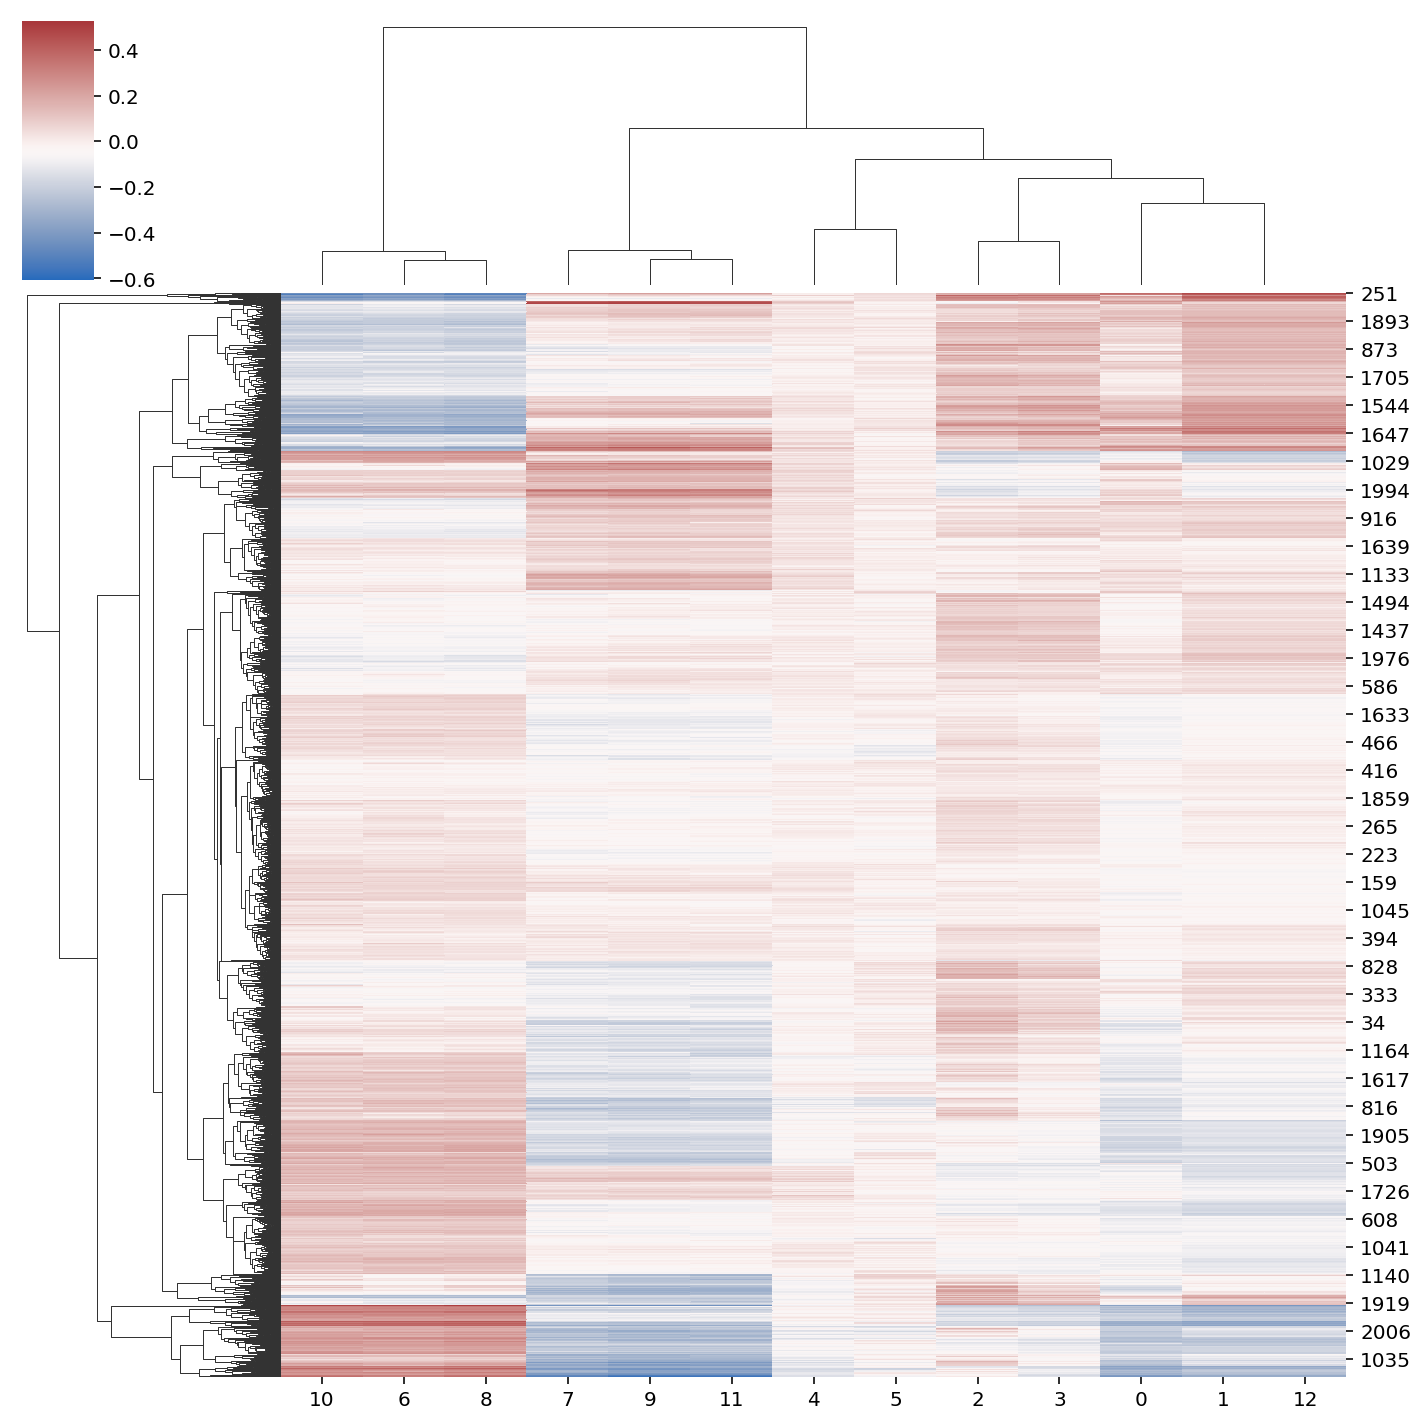

In [170]:
plt.figure()
g = sns.clustermap(df_3, cmap="vlag")
plt.show()

In [5]:
# plt.figure()
# sns.heatmap(df_3)
# plt.show()

In [27]:
hf_n = ['n_nuclei', 'nuclei_total_area', 
                                                          'nuclei_mean_area', 'nuclei_std_area', 
                                                          'eccentricity', 'solidity', 'mean_pix_r', 'std_pix_r', 
                                                          'mean_pix_g', 'std_pix_g', 'mean_pix_b', 'std_pix_b',
                                                          'nuclei_total_area_per_tile']

In [29]:
for i in [10,6,8,7,9,11,4,5,2,3,0,1,12]:
    print(hf_n[i])

mean_pix_b
mean_pix_r
mean_pix_g
std_pix_r
std_pix_g
std_pix_b
eccentricity
solidity
nuclei_mean_area
nuclei_std_area
n_nuclei
nuclei_total_area
nuclei_total_area_per_tile


In [36]:
Sample1_morphology = Sample1_SME.copy()

In [37]:
Sample1_morphology

AnnData object with n_obs × n_vars = 2702 × 21949
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'tile_path', 'n_nuclei', 'nuclei_total_area', 'nuclei_mean_area', 'nuclei_std_area', 'eccentricity', 'solidity', 'mean_pix_r', 'std_pix_r', 'mean_pix_g', 'std_pix_g', 'mean_pix_b', 'std_pix_b', 'nuclei_total_area_per_tile'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'log1p', 'pca', 'gene_expression_correlation', 'physical_distance', 'morphological_distance', 'weights_matrix_all', 'weights_matrix_pd_gd', 'weights_matrix_pd_md', 'weights_matrix_gd_md'
    obsm: 'spatial', 'X_pca', 'X_tile_feature', 'X_morphology', 'imputed_data', 'top_weights', 'raw_SME_normalized'
    varm: 'PCs'

In [47]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Optional, Union
from anndata import AnnData


def BB_plot(
    adata: AnnData,
    library_id: str = None,
    name: str = None,
    data_alpha: float = 0.8,
    tissue_alpha: float = 1.0,
    cmap: str = "Spectral_r",
    spot_size: tuple = (5, 40),
    index: int = None,
    ob2: str = None,
    show_color_bar: bool = True,
    show_size_legend: bool = True,
    show_axis: bool = False,
    cropped: bool = True,
    margin: int = 100,
    dpi: int = 150,
    output: str = None,
) -> Optional[AnnData]:
    """\
        QC plot for sptial transcriptomics data.

        Parameters
        ----------
        adata
            Annotated data matrix.
        library_id
            Library id stored in AnnData.
        data_alpha
            Opacity of the spot.
        tissue_alpha
            Opacity of the tissue.
        cmap
            Color map to use.
        spot_size
            Size of the spot (min, max).
        show_color_bar
            Show color bar or not.
        show_axis
            Show axis or not.
        show_size_legend
            Show size legend or not.
        name
            Name of the output figure file.
        output
            Save the figure as file or not.
        copy
            Return a copy instead of writing to adata.
        Returns
        -------
        Nothing
        """

    imagecol = adata.obs["imagecol"]
    imagerow = adata.obs["imagerow"]
    from sklearn.preprocessing import MinMaxScaler

    ob_2 = adata.obsm[ob2][:,index]
    
    # plt.rcParams['figure.dpi'] = dpi

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()

    vmin = min(ob_2)
    vmax = max(ob_2)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(
        adata.obs["imagecol"],
        adata.obs["imagerow"],
        edgecolor="none",
        alpha=data_alpha,
        s=6,
        marker="o",
        vmin=vmin,
        vmax=vmax,
        cmap=plt.get_cmap(cmap),
        c=ob_2,
    )

    if show_color_bar:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(a,
                   width="100%",
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.0, 0.73, 0.05, 0.35),
                   bbox_transform=a.transAxes,
                   borderpad=4.3,
                   )
        cb = plt.colorbar(plot, cax=axins)
        cb.ax.set_xlabel(ob2, fontsize=10)
        cb.ax.xaxis.set_label_coords(0.98, 1.20)
        cb.outline.set_visible(False)

#     if show_size_legend:
#         size_min, size_max = spot_size
#         markers = [size_min, size_min + 1 / 3 * (size_max - size_min),
#                    size_min + 2 / 3 * (size_max - size_min), size_max]
#         legend_markers = [plt.scatter([], [], s=i, c="grey") for i in markers]
#         labels = [str(float((scaler.inverse_transform(np.array(i).reshape(1, 1)))))
#                   for i in markers]
#         a.legend(handles=legend_markers, labels=labels, loc='lower left', bbox_to_anchor=(1, 0.05),
#                    scatterpoints=1, frameon=False, title=ob1)

    if not show_axis:
        a.axis("off")
    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][
        adata.uns["spatial"][library_id]["use_quality"]
    ]
    # Overlay the tissue image
    a.imshow(
        image,
        alpha=tissue_alpha,
        zorder=-1,
    )

    if cropped:
        a.set_xlim(imagecol.min() - margin, imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin, imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])
        # plt.gca().invert_yaxis()

    # fig.tight_layout()
    if output is not None:
        fig.savefig(output + "/" + name, dpi=dpi, bbox_inches="tight", pad_inches=0)

    plt.show()




In [39]:
import umap

In [40]:
reducer = umap.UMAP(n_components=3)

In [41]:
embedding = reducer.fit_transform(Sample1_morphology.obsm["X_tile_feature"])

In [42]:
embedding.shape

(2702, 3)

In [43]:
Sample1_morphology.obs["UMAP1"] = embedding[:,0]
Sample1_morphology.obs["UMAP2"] = embedding[:,1]
Sample1_morphology.obs["UMAP3"] = embedding[:,2]

In [3]:
# BB_plot(Sample1_morphology, ob2="UMAP1")

In [4]:
# BB_plot(Sample1_morphology, ob2="UMAP2")

In [2]:
# BB_plot(Sample1_morphology, ob2="UMAP3")

In [1]:
# for i in range(1024):
#     BB_plot(Sample1_morphology, ob2="X_tile_feature", index=i)